In [0]:
# Load libraries

#import seaborn as sns
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler


In [2]:
# Load dataset
from google.colab import drive
drive.mount('/content/gdrive')

filename = 'df_highway_2012_4mon_sample.h5'

df_LA = pd.read_hdf('/content/gdrive/My Drive/NNDL-data/' + filename)



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#fdr_tt['measurement_tstamp'] = pd.to_datetime(fdr_tt['measurement_tstamp'])
df_LA.dtypes
df_LA.shape


(34272, 207)

## Data Normalization

In [3]:

spd_mat = df_LA.to_numpy()

print(spd_mat.shape)

spd_scaler = MinMaxScaler(feature_range=(0, 1))
spd_mat = spd_scaler.fit_transform(spd_mat)

#spd_std_scaler = StandardScaler(with_mean=True, with_std=True)
#spd_mat = spd_std_scaler.fit_transform(spd_mat)

n_out = spd_mat.shape[-1]


(34272, 207)


## Data Generators

In [0]:

# This generator function is modified from Chollet (2018), Deep Learning with Python

def generator_mat(data, lag, ahead, min_ind, max_ind, shuffle=False, batch_size=128, step=1):
    if max_ind is None:
        max_ind = len(data) - ahead - 1
    i = min_ind + lag
    while 1:
        if shuffle:
            rows = np.random.randint(min_ind+lag, max_ind, size=batch_size)
        else:
            if i+batch_size >= max_ind:
                i=min_ind+lag
            rows = np.arange(i,min(i+batch_size, max_ind))
            i += len(rows)
        
        # change to following for multivar (>1 columns)
        samples = np.zeros((len(rows),lag//step, data.shape[-1]))
        targets = np.zeros((len(rows),data.shape[-1]))
        
        for j, row in enumerate(rows):
            indices = range(rows[j]-lag, rows[j], step)
            samples[j]= data[indices]
            targets[j] = data[rows[j] + ahead][:] #index of output vectors
            
        yield samples, targets

In [0]:
# Setting data generation parameters

lag = 3 # lag of 15 minutes
step = 1 # this is a potential parameter to be optimized
ahead = 3 # 3, 6, 12 to be used - predicting 15, 30, 60-min into the future
batch_size = 128



In [0]:
# 119 days total
# 70% -> 83 days for training = 23904 obs
# 20% -> 23 days for valid
# Rest -> test
23*24*12 + 23904

30528

In [0]:
gen_tr = generator_mat(spd_mat,lag=lag,ahead=ahead,
                   min_ind=0,max_ind=23904,shuffle=False,step=step,batch_size=batch_size)
gen_val = generator_mat(spd_mat,lag=lag,ahead=ahead,
                   min_ind=23905,max_ind=30528,step=step,batch_size=batch_size)
gen_tes = generator_mat(spd_mat,lag=lag,ahead=ahead,
                   min_ind=30529,max_ind=None,step=step,batch_size=batch_size)
val_steps = (30528 - 23905 - lag) // batch_size
test_steps = (34272 - 30529 - lag) // batch_size

In [0]:
import keras.backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

## Baseline Models

In [11]:
# Simple baseline model
def prev_week_val():
    error_mae = []
    error_mse = []
    error_rmse = []
    for step in range(val_steps):
        samples, targets = next(gen_val)
        preds = samples[:,-1,:]
        # univariate
        #preds = samples[:,-1]
        mae = np.mean(np.abs(preds-targets))
        mse = np.mean(np.square(preds-targets))
        rmse = np.sqrt(mse)
        error_mae.append(mae)
        error_mse.append(mse)
        error_rmse.append(rmse)
    
    #print(np.isnan(error_mape).sum)
    print(np.mean(error_mae))
    print(np.mean(error_mse))
    print(np.mean(error_rmse))

prev_week_val()


0.06417778790918481
0.023816428493916134
0.14381504134852688


In [12]:
# Baseline model for Vector Auto-Regression (VAR) time series model

from statsmodels.tsa.vector_ar.var_model import VAR

def eval_var(traffic_reading_df, n_lags=3):
    n_forwards = [1, 3, 6, 12]
    y_predicts, y_test = var_predict(traffic_reading_df, n_forwards = n_forwards,n_lags=n_lags,
                                     test_ratio=0.3)
    for i, horizon in enumerate(n_forwards):
        mae = np.mean(np.abs(y_predicts-y_test))
        mse =  np.mean(np.square(y_predicts-y_test))
        rmse = np.sqrt(mse)
        line = 'VAR\t%d\t%.3f\t%.3f\t%.3f' % (horizon, mae, mse, rmse)
        print(line)
        
def var_predict(df, n_forwards=(1, 3), n_lags=4, test_ratio=0.2):
    """
    Multivariate time series forecasting using Vector Auto-Regressive Model.
    :param df: pandas.DataFrame, index: time, columns: sensor id, content: data.
    :param n_forwards: a tuple of horizons.
    :param n_lags: the order of the VAR model.
    :param test_ratio:
    :return: [list of prediction in different horizon], dt_test
    """
    n_sample, n_output = df.shape
    n_test = int(round(n_sample * test_ratio))
    n_train = n_sample - n_test
    df_train, df_test = df[:n_train], df[n_train:]

    #scaler = StandardScaler(with_mean=True, with_std=True)
    #data = scaler.fit_transform(df_train)
    data = df_train
    var_model = VAR(data)
    var_result = var_model.fit(n_lags)
    max_n_forwards = np.max(n_forwards)
    
    # Do forecasting.
    result = np.zeros(shape=(len(n_forwards), n_test, n_output))
    start = n_train - n_lags - max_n_forwards + 1
    
    for input_ind in range(start, n_sample - n_lags):
#        prediction = var_result.forecast(scaler.transform(df[input_ind: input_ind + n_lags]), max_n_forwards)
        prediction = var_result.forecast(df[input_ind: input_ind + n_lags], max_n_forwards)
        for i, n_forward in enumerate(n_forwards):
            result_ind = input_ind - n_train + n_lags + n_forward - 1
            #print(result_ind)
            if 0 <= result_ind < n_test:
                result[i, result_ind, :] = prediction[n_forward - 1, :]
    
    df_predicts = []
    for i, n_forward in enumerate(n_forwards):
#        df_predicts = scaler.inverse_transform(result[i])
        df_predicts = result[i]
    return df_predicts, df_test
  
eval_var(spd_mat)

VAR	1	0.123	0.044	0.210
VAR	3	0.123	0.044	0.210
VAR	6	0.123	0.044	0.210
VAR	12	0.123	0.044	0.210


## Simpler single-layer Architectures

In [9]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()

model.add(layers.Flatten(input_shape=(lag // step, spd_mat.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(n_out))
model.summary()

model.compile(optimizer=RMSprop(decay=0.001), loss=root_mean_squared_error)
history = model.fit_generator(gen_tr,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=gen_val,
                              validation_steps=val_steps)
model.save('/content/gdrive/My Drive/NNDL-project/fnn_2_layer_64_decay_Std_3step_rmse.h5')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 621)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                19904     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_4 (Dense)              (None, 207)               13455     
Total params: 35,471
Trainable params: 35,471
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
500/500 [==============================] - 4s 9ms/step - loss: 0.2081 - val_loss: 0.1992
Epoch 2/40
500/500 [==============================] - 4s 8ms/step - loss: 0.1702 - val_loss: 0.1874
Epoch 3/40
500/500 [============================

In [16]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()

model.add(layers.Flatten(input_shape=(lag // step, spd_mat.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(n_out))
model.summary()

model.compile(optimizer=RMSprop(decay=0.001), loss=root_mean_squared_error)
history = model.fit_generator(gen_tr,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=gen_val,
                              validation_steps=val_steps)
model.save('/content/gdrive/My Drive/NNDL-project/fnn_2_layer_64_Std_3step_rmse.h5')



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 621)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                19904     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_9 (Dense)              (None, 207)               13455     
Total params: 35,471
Trainable params: 35,471
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
500/500 [==============================] - 3s 6ms/step - loss: 0.2111 - val_loss: 0.2088
Epoch 2/40
500/500 [==============================] - 3s 5ms/step - loss: 0.1724 - val_loss: 0.1886
Epoch 3/40
500/500 [============================

In [17]:
# Single layer RNN: GRU 
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(64,
                     input_shape=(None, spd_mat.shape[-1])))
model.add(layers.Dense(n_out))
model.summary()

model.compile(optimizer=RMSprop(), loss=root_mean_squared_error)
history = model.fit_generator(gen_tr,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=gen_val,
                              validation_steps=val_steps)
model.save('/content/gdrive/My Drive/NNDL-project/gru_1_layer_simple_64_3step_rmse.h5')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 64)                52224     
_________________________________________________________________
dense_10 (Dense)             (None, 207)               13455     
Total params: 65,679
Trainable params: 65,679
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
500/500 [==============================] - 6s 12ms/step - loss: 0.1865 - val_loss: 0.1865
Epoch 2/40
500/500 [==============================] - 5s 11ms/step - loss: 0.1665 - val_loss: 0.1896
Epoch 3/40
500/500 [==============================] - 5s 11ms/step - loss: 0.1615 - val_loss: 0.1777
Epoch 4/40
500/500 [==============================] - 6s 12ms/step - loss: 0.1557 - val_loss: 0.1946
Epoch 5/40
500/500 [==============================] - 5s 11ms/step - loss: 0.1541 - val_loss: 0.1806
Epoch 6

In [22]:
# Single layer RNN: GRU 
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(128,
                     input_shape=(None, spd_mat.shape[-1])))
model.add(layers.Dense(n_out))
model.summary()

model.compile(optimizer=RMSprop(decay=0.001), loss=root_mean_squared_error)
m2 = model
history = m2.fit_generator(gen_tr,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=gen_val,
                              validation_steps=val_steps)
model.save('/content/gdrive/My Drive/NNDL-project/gru_1_layer_128_3step_rmse.h5')

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_15 (GRU)                 (None, 128)               129024    
_________________________________________________________________
dense_11 (Dense)             (None, 207)               26703     
Total params: 155,727
Trainable params: 155,727
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
500/500 [==============================] - 9s 17ms/step - loss: 0.1800 - val_loss: 0.1861
Epoch 2/40
500/500 [==============================] - 5s 11ms/step - loss: 0.1555 - val_loss: 0.1759
Epoch 3/40
500/500 [==============================] - 5s 11ms/step - loss: 0.1466 - val_loss: 0.1679
Epoch 4/40
500/500 [==============================] - 5s 11ms/step - loss: 0.1412 - val_loss: 0.1632
Epoch 5/40
500/500 [==============================] - 5s 11ms/step - loss: 0.1387 - val_loss: 0.1620
Epoc

In [0]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss for 1 Layer GRU 64 units w/ Dropout')
plt.legend()

plt.show()

In [9]:
# LSTM 64 units 
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.LSTM(64,
                     input_shape=(None, spd_mat.shape[-1])))
model.add(layers.Dense(n_out))

model.summary()
model.compile(optimizer=RMSprop(decay=0.001), loss=root_mean_squared_error)
history = model.fit_generator(gen_tr,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=gen_val,
                              validation_steps=val_steps)
model.save('/content/gdrive/My Drive/NNDL-project/lstm_1_layer_64_Std_3step_rmse.h5')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                69632     
_________________________________________________________________
dense_2 (Dense)              (None, 207)               13455     
Total params: 83,087
Trainable params: 83,087
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
500/500 [==============================] - 7s 13ms/step - loss: 0.1877 - val_loss: 0.1818
Epoch 2/40
500/500 [==============================] - 6s 12ms/step - loss: 0.1605 - val_loss: 0.1803
Epoch 3/40
500/500 [==============================] - 6s 12ms/step - loss: 0.1564 - val_loss: 0.1720
Epoch 4/40
500/500 [==============================] - 6s 12ms/step - loss: 0.1508 - val_loss: 0.1691
Epoch 5/40
500/500 [==============================] - 6s 12ms/step - loss: 0.1475 - val_loss: 0.1703
Epoch 6

In [17]:
# LSTM 128 units 
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.LSTM(128,
                     input_shape=(None, spd_mat.shape[-1])))
model.add(layers.Dense(n_out))

model.summary()
model.compile(optimizer=RMSprop(decay=0.001), loss=root_mean_squared_error)
history = model.fit_generator(gen_tr,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=gen_val,
                              validation_steps=val_steps)
model.save('/content/gdrive/My Drive/NNDL-project/lstm_1_layer_128_Std_3step_rmse.h5')

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 128)               172032    
_________________________________________________________________
dense_10 (Dense)             (None, 207)               26703     
Total params: 198,735
Trainable params: 198,735
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
500/500 [==============================] - 9s 18ms/step - loss: 0.1798 - val_loss: 0.1897
Epoch 2/40
500/500 [==============================] - 6s 12ms/step - loss: 0.1547 - val_loss: 0.1728
Epoch 3/40
500/500 [==============================] - 6s 12ms/step - loss: 0.1470 - val_loss: 0.1683
Epoch 4/40
500/500 [==============================] - 6s 12ms/step - loss: 0.1408 - val_loss: 0.1665
Epoch 5/40
500/500 [==============================] - 6s 12ms/step - loss: 0.1389 - val_loss: 0.1877
Epoc

## Deeper Architecture

In [10]:
# Stacked GRU Model - for deeper architecture
# 2 layer 64/64 units

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(64,
                     return_sequences=True,
                     input_shape=(None, spd_mat.shape[-1])))
model.add(layers.GRU(64, activation='relu'))
model.add(layers.Dense(n_out))

model.compile(optimizer=RMSprop(decay=0.001), loss=root_mean_squared_error)
model.summary()
history = model.fit_generator(gen_tr,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=gen_val,
                              validation_steps=val_steps)
model.save('/content/gdrive/My Drive/NNDL-project/gru_2_layer_64_64_3step_rmse.h5')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, None, 64)          52224     
_________________________________________________________________
gru_3 (GRU)                  (None, 64)                24768     
_________________________________________________________________
dense_3 (Dense)              (None, 207)               13455     
Total params: 90,447
Trainable params: 90,447
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
500/500 [==============================] - 9s 19ms/step - loss: 0.1907 - val_loss: 0.1836
Epoch 2/40
500/500 [==============================] - 8s 16ms/step - loss: 0.1666 - val_loss: 0.1847
Epoch 3/40
500/500 [==============================] - 8s 16ms/step - loss: 0.1612 - val_loss: 0.1770
Epoch 4/40
500/500 [==============================] - 8s 16ms/step - loss: 0.

In [28]:
# Stacked GRU Model - for deeper architecture
# 2 layer 128/64 units

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(128,
                     return_sequences=True,
                     input_shape=(None, spd_mat.shape[-1])))
model.add(layers.GRU(64, activation='relu'))
model.add(layers.Dense(n_out))

model.compile(optimizer=RMSprop(decay=0.001), loss=root_mean_squared_error)
model.summary()
m4 = model
history = m4.fit_generator(gen_tr,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=gen_val,
                              validation_steps=val_steps)
#model.save('/content/gdrive/My Drive/NNDL-project/gru_2_layer_128_64_Std_3step_rmse.h5')

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_19 (GRU)                 (None, None, 128)         129024    
_________________________________________________________________
gru_20 (GRU)                 (None, 64)                37056     
_________________________________________________________________
dense_13 (Dense)             (None, 207)               13455     
Total params: 179,535
Trainable params: 179,535
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
500/500 [==============================] - 13s 26ms/step - loss: 0.1959 - val_loss: 0.2082
Epoch 2/40
500/500 [==============================] - 8s 17ms/step - loss: 0.1641 - val_loss: 0.1764
Epoch 3/40
500/500 [==============================] - 8s 17ms/step - loss: 0.1597 - val_loss: 0.1735
Epoch 4/40
500/500 [==============================] - 8s 17ms/step - loss

In [16]:
# Stacked GRU Model - for deeper architecture
# 2 layer 128/64 units
# Adamax

from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam, Adamax

model = Sequential()
model.add(layers.GRU(128,
                     return_sequences=True,
                     input_shape=(None, spd_mat.shape[-1])))
model.add(layers.GRU(64, activation='relu'))
model.add(layers.Dense(n_out))

model.compile(optimizer=Adamax(decay=0.001), loss=root_mean_squared_error)
model.summary()
history = model.fit_generator(gen_tr,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=gen_val,
                              validation_steps=val_steps)
model.save('/content/gdrive/My Drive/NNDL-project/gru_2_layer_128_64_adamax_3step_rmse.h5')

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_13 (GRU)                 (None, None, 128)         129024    
_________________________________________________________________
gru_14 (GRU)                 (None, 64)                37056     
_________________________________________________________________
dense_9 (Dense)              (None, 207)               13455     
Total params: 179,535
Trainable params: 179,535
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
500/500 [==============================] - 11s 22ms/step - loss: 0.2093 - val_loss: 0.1887
Epoch 2/40
500/500 [==============================] - 8s 16ms/step - loss: 0.1745 - val_loss: 0.1822
Epoch 3/40
500/500 [==============================] - 8s 17ms/step - loss: 0.1681 - val_loss: 0.1822
Epoch 4/40
500/500 [==============================] - 8s 17ms/step - loss:

In [13]:
# Stacked LSTM Model - for deeper architecture
# 2 layer 128/64 units

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.LSTM(128,
                     return_sequences=True,
                     input_shape=(None, spd_mat.shape[-1])))
model.add(layers.LSTM(64, activation='relu'))
model.add(layers.Dense(n_out))

model.compile(optimizer=RMSprop(decay=0.001), loss=root_mean_squared_error)
model.summary()
history = model.fit_generator(gen_tr,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=gen_val,
                              validation_steps=val_steps)
model.save('/content/gdrive/My Drive/NNDL-project/lstm_2_layer_128_64_Std_3step_rmse.h5')

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, None, 128)         172032    
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_6 (Dense)              (None, 207)               13455     
Total params: 234,895
Trainable params: 234,895
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
500/500 [==============================] - 12s 24ms/step - loss: 0.2066 - val_loss: 0.2055
Epoch 2/40
500/500 [==============================] - 10s 20ms/step - loss: 0.1703 - val_loss: 0.1799
Epoch 3/40
500/500 [==============================] - 10s 21ms/step - loss: 0.1645 - val_loss: 0.1783
Epoch 4/40
500/500 [==============================] - 12s 23ms/step - lo

In [14]:
# Stacked GRU Model - for deeper architecture
# 2 layer 256/128 units

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(256,
                     return_sequences=True,
                     input_shape=(None, spd_mat.shape[-1])))
model.add(layers.GRU(128, activation='relu'))
model.add(layers.Dense(n_out))

model.compile(optimizer=RMSprop(decay=0.001), loss=root_mean_squared_error)
model.summary()
history = model.fit_generator(gen_tr,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=gen_val,
                              validation_steps=val_steps)
model.save('/content/gdrive/My Drive/NNDL-project/gru_2_layer_256_128_Std_3step_rmse.h5')

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_8 (GRU)                  (None, None, 256)         356352    
_________________________________________________________________
gru_9 (GRU)                  (None, 128)               147840    
_________________________________________________________________
dense_7 (Dense)              (None, 207)               26703     
Total params: 530,895
Trainable params: 530,895
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
500/500 [==============================] - 11s 21ms/step - loss: 0.1931 - val_loss: 0.1892
Epoch 2/40
500/500 [==============================] - 9s 17ms/step - loss: 0.1623 - val_loss: 0.1746
Epoch 3/40
500/500 [==============================] - 9s 17ms/step - loss: 0.1530 - val_loss: 0.2066
Epoch 4/40
500/500 [==============================] - 9s 17ms/step - loss:

In [27]:
# Stacked GRU 3 layer 256/256/128 units

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(256,
                     return_sequences=True,
                     input_shape=(None, spd_mat.shape[-1])))
model.add(layers.GRU(256,
                     return_sequences=True,
                     input_shape=(None, spd_mat.shape[-1])))
model.add(layers.GRU(128, activation='relu'))
model.add(layers.Dense(n_out))

model.compile(optimizer=RMSprop(decay=0.001), loss=root_mean_squared_error)
model.summary()
m3 = model
history = m3.fit_generator(gen_tr,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=gen_val,
                              validation_steps=val_steps)
#model.save('/content/gdrive/My Drive/NNDL-project/gru_3_layer_256_256_128_Std_3step_rmse.h5')

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_16 (GRU)                 (None, None, 256)         356352    
_________________________________________________________________
gru_17 (GRU)                 (None, None, 256)         393984    
_________________________________________________________________
gru_18 (GRU)                 (None, 128)               147840    
_________________________________________________________________
dense_12 (Dense)             (None, 207)               26703     
Total params: 924,879
Trainable params: 924,879
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
500/500 [==============================] - 17s 34ms/step - loss: 0.1964 - val_loss: 0.2094
Epoch 2/40
500/500 [==============================] - 12s 25ms/step - loss: 0.1670 - val_loss: 0.1816
Epoch 3/40
500/500 [=====================

## Comparing Prediciton

In [0]:
# Prediction on test set

from keras.models import load_model 

m0 = load_model('/content/gdrive/My Drive/NNDL-project/fnn_2_layer_64_Std_3step_full.h5')
m1 = load_model('/content/gdrive/My Drive/NNDL-project/gru_1_layer_simple_64_3step_full.h5')
m2 = load_model('/content/gdrive/My Drive/NNDL-project/gru_2_layer_128_64_Std_3step_full.h5')
m3 = load_model('/content/gdrive/My Drive/NNDL-project/gru_2_layer_128_64_12Lag.h5')
m4 = load_model('/content/gdrive/My Drive/NNDL-project/gru_2_layer_128_64_64Lag.h5')



In [0]:

test_pred0 = m0.predict_generator(gen_tes, steps=test_steps)
test_pred1 = m1.predict_generator(gen_tes, steps=test_steps)
test_pred2 = m2.predict_generator(gen_tes, steps=test_steps)
test_pred3 = m3.predict_generator(gen_tes_12, steps=test_steps_12)
test_pred4 = m4.predict_generator(gen_tes_64, steps=test_steps_64)

In [0]:
# Prediction on test set using different MAE & RMSE models

from keras.models import load_model 

#m0 = load_model('/content/gdrive/My Drive/NNDL-project/gru_2_layer_128_64_Std_3step_full.h5')
m1 = model #load_model('/content/gdrive/My Drive/NNDL-project/lstm_1_layer_128_Std_3step_rmse.h5')
m2 = load_model('/content/gdrive/My Drive/NNDL-project/gru_1_layer_128_3step_rmse.h5')
m3 = load_model('/content/gdrive/My Drive/NNDL-project/gru_3_layer_256_256_128_Std_3step_rmse.h5')
m4 = load_model('/content/gdrive/My Drive/NNDL-project/gru_2_layer_128_64_Std_3step_rmse.h5')

In [0]:

test_pred0_mvr = m0.predict_generator(gen_tes, steps=test_steps)
test_pred1_mvr = m1.predict_generator(gen_tes, steps=test_steps)
test_pred2_mvr = m2.predict_generator(gen_tes, steps=test_steps)
test_pred3_mvr = m3.predict_generator(gen_tes, steps=test_steps)
test_pred4_mvr = m4.predict_generator(gen_tes, steps=test_steps)

In [0]:
from sklearn.metrics import mean_absolute_error

print(test_pred0.shape)
print(mean_absolute_error(test_pred0, spd_mat[30529:30529+3712,]))
print(mean_absolute_error(test_pred1, spd_mat[30529:30529+3712,]))
print(mean_absolute_error(test_pred2, spd_mat[30529:30529+3712,]))
print(mean_absolute_error(test_pred3, spd_mat[30529:30529+3712,]))
print(mean_absolute_error(test_pred4, spd_mat[30529:30529+3584,]))

(3712, 207)
0.24681336269955412
0.2765968770823736
0.2598719837401443
0.26820819427270565
0.2663786771825922


In [0]:

abs_err0 = np.absolute(test_pred0_mvr, spd_mat[30529:30529+3712,])
mean_abs_err0 = np.mean(abs_err0,axis=0)
#print(mean_abs_err1.shape)
#print(np.var(abs_err1,axis=1))

abs_err1 = np.absolute(test_pred1_mvr, spd_mat[30529:30529+3712,])
mean_abs_err1 = np.mean(abs_err1,axis=0)

abs_err2 = np.absolute(test_pred2_mvr, spd_mat[30529:30529+3712,])
mean_abs_err2 = np.mean(abs_err2,axis=0)

abs_err3 = np.absolute(test_pred3_mvr, spd_mat[30529:30529+3712,])
mean_abs_err3 = np.mean(abs_err3,axis=0)

abs_err4 = np.absolute(test_pred4_mvr, spd_mat[30529:30529+3712,])
mean_abs_err4 = np.mean(abs_err4,axis=0)


In [25]:
print(mean_abs_err0.shape)

(207,)


<Figure size 432x288 with 0 Axes>

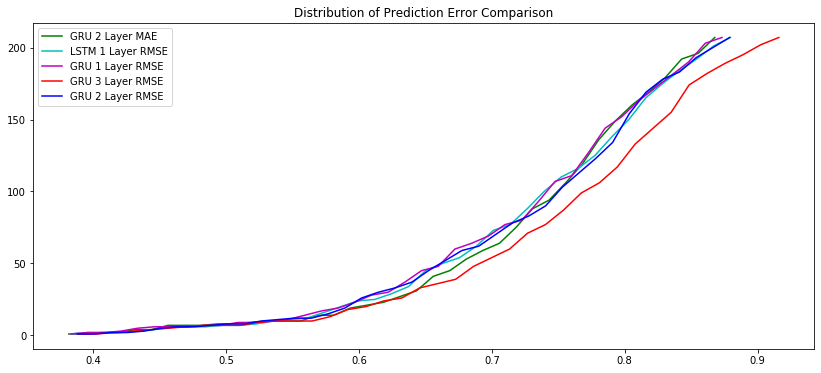

In [34]:
# Plotting distribution of error for MAE & RMSE-based models

import matplotlib.pyplot as plt

# Plot
plt.figure()
plt.figure(figsize=(14,6))

values, base = np.histogram(mean_abs_err0, bins=40)
cumulative = np.cumsum(values)
plt.plot(base[:-1], cumulative, c='g', label='GRU 2 Layer MAE')

values, base = np.histogram(mean_abs_err1, bins=40)
cumulative = np.cumsum(values)
plt.plot(base[:-1], cumulative, c='c', label='LSTM 1 Layer RMSE')

values, base = np.histogram(mean_abs_err2, bins=40)
cumulative = np.cumsum(values)
plt.plot(base[:-1], cumulative, c='m', label='GRU 1 Layer RMSE')

values, base = np.histogram(mean_abs_err3, bins=40)
cumulative = np.cumsum(values)
plt.plot(base[:-1], cumulative, c='r', label='GRU 3 Layer RMSE')

values, base = np.histogram(mean_abs_err4, bins=40)
cumulative = np.cumsum(values)
plt.plot(base[:-1], cumulative, c='b', label='GRU 2 Layer RMSE')
plt.title('Distribution of Prediction Error Comparison')

plt.legend()



plt.show()